test the build-in model

In [1]:
#import useful libraries
import os
import sys
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input
from skimage import io
import tensorflow as tf
import matplotlib.patches as mpatches
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from functions import *


In [2]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3 
TEST_PATH='./test_set/'# our project
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
n_num=num(dirname='tifs_unanalysed/')
#build our test set
test_ids = next(os.walk(TEST_PATH))[1]
X_test = np.zeros((n_num, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#just to ensure that len of X_test is equal to len of sizes_test
sizes_test = []
sys.stdout.flush()
n=0
for id_ in tqdm(test_ids, total=len(test_ids)):
    path = TEST_PATH + id_+'/images/'
    dir_3=os.listdir(path)
    k=len(dir_3)
    for i in range(0,k): 
        img = imread(path +dir_3[i])[:,:,:IMG_CHANNELS] # look for all pictures with name Series001
        sizes_test.append([img.shape[0], img.shape[1]])# append sizes of figures i.e. 256*256 pixel: [256,256]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n]=img
        n+=1

100%|██████████| 24/24 [00:01<00:00, 13.34it/s]


In [17]:
#modified from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html
for id_ in tqdm(test_ids, total=len(test_ids)):
    path = TEST_PATH + id_+'/images/'
    dir_3=os.listdir(path)
    k=len(dir_3)
    for i in range(0,k):   
        image = imread(path +dir_3[i])[:,:,:3]# load the pictures
        image = rgb2gray(image) #convert to greyscale after loading
        thresh = threshold_otsu(image) # perform automatic thresholding
        bw = closing(image >thresh,square(3)) #convert 0，1 to bool
        # remove artifacts connected to image border
        cleared = clear_border(bw)
        # label image regions
        label_image = label(cleared)
        # to make the background transparent, pass the value of `bg_label`,
        # and leave `bg_color` as `None` and `kind` as `overlay`
        image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(image_label_overlay)
        for region in regionprops(label_image):
            # take regions with large enough areas
            if region.area >= 150:
                # draw rectangle around segmented coins
                minr, minc, maxr, maxc = region.bbox
                rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)
        ax.set_axis_off()
        plt.tight_layout()
        figure_save_path ='label_set/'+id_
        if not os.path.exists(figure_save_path):# if directory not exist, create it
            os.makedirs(figure_save_path)   
        plt.savefig(os.path.join(figure_save_path , '{}'.format(dir_3[i])),bbox_inches='tight', pad_inches = -0.1)
        plt.close()
                        

100%|██████████| 30/30 [00:23<00:00,  1.30it/s]


In [3]:
#load the model and use it to make predicted results
model = load_model('model.h5', custom_objects={'accuracy': 'accuracy'})
preds_test = model.predict(X_test, verbose=1)

#Threshold predictions
preds_test_t = (preds_test > 0.8).astype(np.uint8)


6/6 [==============================] - 2s 326ms/step


In [4]:
print(preds_test)

[[[[4.65231001e-01]
   [4.20446903e-01]
   [4.92330253e-01]
   ...
   [3.74319017e-01]
   [3.96093369e-01]
   [4.31944877e-01]]

  [[4.41269070e-01]
   [4.26382244e-01]
   [4.00069654e-01]
   ...
   [3.34890723e-01]
   [3.60255629e-01]
   [4.63217884e-01]]

  [[4.68425363e-01]
   [4.43553984e-01]
   [4.46408629e-01]
   ...
   [4.12558138e-01]
   [3.98918837e-01]
   [4.62441951e-01]]

  ...

  [[3.64574641e-01]
   [3.66827011e-01]
   [3.09820950e-01]
   ...
   [7.44584084e-01]
   [5.68389177e-01]
   [5.38675606e-01]]

  [[3.60615671e-01]
   [3.16452950e-01]
   [3.06679070e-01]
   ...
   [7.48842895e-01]
   [5.22082627e-01]
   [5.12865841e-01]]

  [[3.84476781e-01]
   [3.48286271e-01]
   [3.77717614e-01]
   ...
   [6.69632137e-01]
   [5.33948839e-01]
   [5.09799361e-01]]]


 [[[4.25551891e-01]
   [3.80388439e-01]
   [3.99368465e-01]
   ...
   [6.94193602e-01]
   [6.74919128e-01]
   [4.74743336e-01]]

  [[3.70155573e-01]
   [3.48035157e-01]
   [3.11384857e-01]
   ...
   [8.95146549e-01]
 

In [5]:
ID=0
ID_dir={}
for id_ in test_ids:
    path = TEST_PATH + id_+'/images/'
    dir_3=os.listdir(path)
    k=len(dir_3)
    for i in range(0,k): 
        ID_dir[ID]=dir_3[i]
        ID+=1       

KeyError: 143

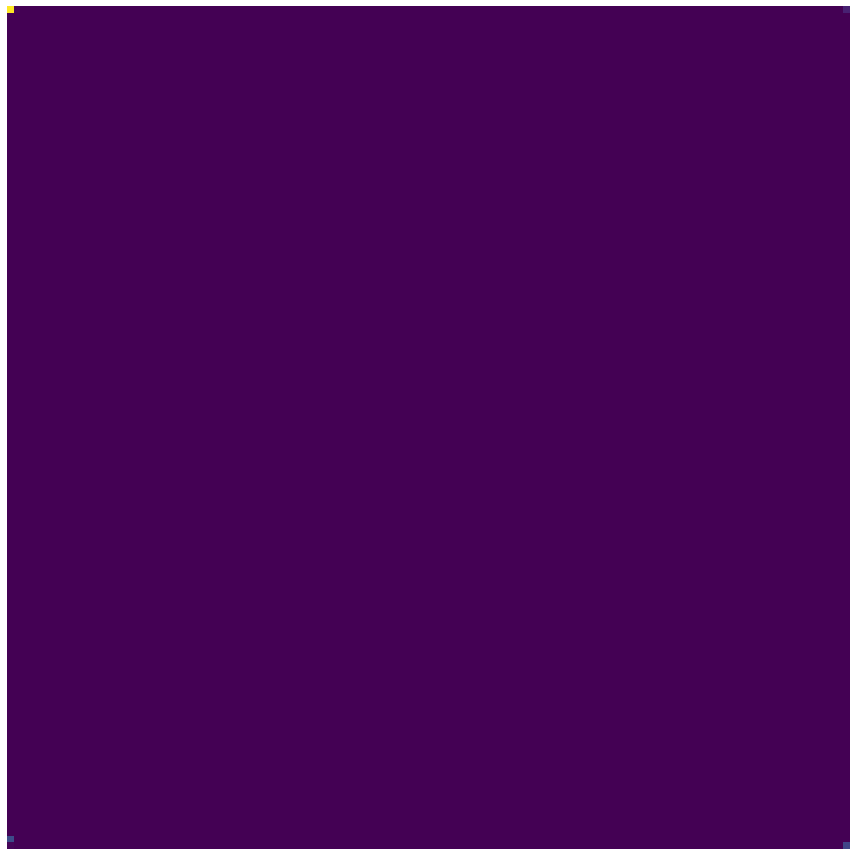

In [7]:
# Perform a sanity check on some random training samples
for i in range(0,len(X_test)):
    plt.figure(figsize=(12,12))
    plt.imshow(preds_test[i])
    #plt.title('Predictions')
    plt.axis('off')
    plt.tight_layout()
    figure_save_path ='pred_set/'
    if not os.path.exists(figure_save_path):# if directory not exist, create it
        os.makedirs(figure_save_path)   
    plt.savefig(os.path.join(figure_save_path , '{}'.format(ID_dir[i])),bbox_inches='tight', pad_inches = -0.1)
    plt.close()    

In [8]:

path = './pred_set/'
dirs=os.listdir(path)
kk=len(dirs)
for i in range(0,kk):
    name=path+str(dirs[i])
    sep_count_cells(filename=name)
    figure_save_path ='sep_set/'
    if not os.path.exists(figure_save_path):# if directory not exist, create it
        os.makedirs(figure_save_path)   
    plt.savefig(os.path.join(figure_save_path , '{}'.format(dirs[i])),bbox_inches='tight', pad_inches = -0.1)
    plt.close()


c:\Users\ZKR\Desktop\PHAS0077-Scientific-Computing-Individual-Research-Project\functions.py:230: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=50, labels=thresh)
